In [19]:
import sys
sys.path.append('/usr/wrk/people9/sima9999/git/pyOMA')
import os
import numpy as np
from uncertainty.data_manager import DataManager, HiddenPrints
import logging
logger = logging.getLogger('uncertainty.data_manager')
logger.setLevel(level=logging.DEBUG)
from core.StabilDiagram import StabilCalc
title='uq_acqui'
working_dir = os.path.join('/dev/shm', str(os.getuid()), 'work')


if os.getlogin()=='womo1998':
    base='/vegas/scratch/womo1998/'
else:
    base='/usr/scratch4/sima9999/work/'
result_dir = os.path.join(base, f'modal_uq/{title}/')
data_manager = DataManager.from_existing(dbfile_in=f'{title}.nc', 
                                         result_dir=result_dir)

DEBUG:uncertainty.data_manager:opening existing file uq_acqui.nc


In [20]:

with data_manager.get_database(database='in', rw=False) as ds:
#     del ds['bits']
#     del ds['window']
    pass
display(ds)
#     for jid in ds.ids:
#         ds.model_order.loc[jid]
#         if np.isnan(ds.modal_frequencies.loc[jid]).all():
#             i+=1
#         else:
#             ds._exceptions.loc[jid] = ''
# display(i)
#     ds.attrs['dbfile_in'] = 'uq_acqui2.nc'
#     ds.attrs['dbfile_out'] = 'uq_acqui2_out.nc'
#     ds.attrs['result_dir'] = '/usr/scratch4/sima9999/work/modal_uq/uq_acqui2/'
#     ds.attrs['title'] = 'uq_acqui2'
    
#display(ds.loc[{'ids':ds._exceptions!=''}])

DEBUG:uncertainty.data_manager:opening existing file uq_acqui.nc


<xarray.Dataset>
Dimensions:       (ids: 1000)
Coordinates:
  * ids           (ids) object 'd5c92dec8c49' '8db9e569abe9' ... '6892f3e8f39e'
Data variables:
    bits2         (ids) int64 23 12 9 29 24 26 21 16 ... 16 26 9 11 14 22 31 32
    damping       (ids) float64 0.01134 0.04043 0.06708 ... 0.08827 0.0781
    freq_scale    (ids) float64 1.807 0.9211 1.894 0.9083 ... 1.37 1.826 1.744
    lumped        (ids) int64 1 1 1 0 1 0 0 1 1 1 1 0 ... 0 1 1 1 0 1 1 1 1 0 1
    method        (ids) object 'blackman-tukey' 'blackman-tukey' ... 'welch'
    num_cycles    (ids) int64 1405 805 1335 1073 1442 ... 1238 559 1065 508 741
    num_modes     (ids) int64 15 17 7 14 7 6 5 7 4 2 ... 20 16 8 13 9 12 8 13 13
    num_sensors   (ids) int64 8 2 8 7 8 3 3 8 2 8 5 7 ... 9 7 2 7 3 8 3 3 5 2 9
    numtaps_fact  (ids) int64 11 27 35 38 11 17 22 18 ... 39 40 36 12 24 26 24
    nyq_rat       (ids) float64 2.636 3.953 2.298 3.001 ... 2.901 3.62 3.937
    order_factor  (ids) int64 9 2 9 9 4 8 7 3 5 4 10 ... 3 6 10 3 8 8 4 3 10 8 6
    snr_db        (ids) float64 -21.0 6.335 -18.4 9.596 ... -6.849 -22.59 -22.01
    tau_max       (ids) int64 78 241 145 211 334 392 ... 305 297 76 279 233 253
    window        (ids) float64 11.39 10.17 14.75 5.278 ... 1.374 4.701 13.34
Attributes:
    date:         datetime.date(2021, 9, 7)
    dbfile_in:    uq_acqui.nc
    dbfile_out:   uq_acqui_out.nc
    entropy:      300507817
    result_dir:   /usr/scratch4/sima9999/work/modal_uq/uq_acqui/
    title:        uq_acqui
    working_dir:  /dev/shm/womo1998/

In [21]:
def func(ds):
    '''
    plot all numerical natural frequencies to get a feeling for their distribution
    
    modal parameters:
    for each jid:
        assign each identified mode to the respective numerical
        mark unidentified and wrongly identified
        compute normalized frequency and damping differences (numerical, identified), MAC values
    
    per-channel output variables:
        reduce to mean and coefficient of variation
    '''
#     for name in ds.data_vars:
#         if name.startswith('_'): continue
#         print(name, ds[name].dims)
    
    num_samples = ds.ids.size
    num_modes = ds.modes.size
    num_channels = ds.channels.size
    
    ds['freq_diff'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['damp_diff'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['modal_assurance'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['unp_num'] = (['ids'], np.zeros((num_samples,)))
    ds['unp_id'] = (['ids'], np.zeros((num_samples,)))    
#     skip=True    
    print_ids = ds.ids[np.linspace(0, num_samples-1, 100, dtype=int)]
    #print(print_ids)
    for jid in ds.ids:
        if jid.item() in print_ids: print('.', end='', flush=True)
#         print(jid.item()
#         if jid!='123a8b385cb9':
#             if skip:continue
#         skip=False
        freq_a = ds['frequencies_a'].loc[jid].dropna('modes', 'all')
        freq_id = ds['modal_frequencies'].loc[jid].dropna('modes', 'all')
        damp_a = ds['damping_a'].loc[jid].dropna('modes', 'all')
        damp_id = ds['modal_damping'].loc[jid].dropna('modes', 'all')
        shapes_a = ds['mode_shapes_a'].loc[jid].dropna('modes', 'all').dropna('channels', 'all')
        shapes_id = ds['mode_shapes'].loc[jid].dropna('modes', 'all').dropna('channels', 'all')
        
        ind_num, ind_id, unp_num, unp_id= pair_modes(freq_a, freq_id,
                                                     shapes_a, shapes_id,)
        n_pairs = len(ind_num)
        ds['unp_num'].loc[jid] = unp_num
        ds['unp_id'].loc[jid] = unp_id
        
        freq_diff = (freq_a[ind_num] - freq_id[ind_id])/(0.5 * (freq_a[ind_num] + freq_id[ind_id]))
        ds['freq_diff'].loc[jid][ind_num] = freq_diff
        damp_diff = (damp_a[ind_num] - damp_id[ind_id])
        ds['damp_diff'].loc[jid][ind_num] = damp_diff
        mac_values = np.diag(StabilCalc.calculateMAC(shapes_a[:,ind_num], shapes_id[:,ind_id]))
        ds['modal_assurance'].loc[jid][ind_num] = mac_values       
    
    print('.', end='\n', flush=True)
    
    #ds['this_delta_f'] = ds['freq_diff'].mean(dim='modes')
    #ds['this_delta_d'] = ds['damp_diff'].mean(dim='modes')
    #ds['this_mac'] = ds['modal_assurance'].mean(dim='modes')
    
    ds['duration'] = ds.num_cycles/ds.frequencies_a.min(dim='modes')
#     ds['window'] = ('ids', ds.window.data=='hann', {'dist_type': 'integers', 'dist_params': np.array([0,2])})
    
    #dt_fact=0.01
    ds['deltat'] = 1 / ds.fs
    ds['timesteps'] = ds.duration / ds.deltat # N
    ds['bits'] = ds['bits2']
    ds['bits_eff']=(np.log(ds.margin*(2**ds.bits))/np.log(2)).mean('channels')
    
    ds.unp_num.attrs = {'dist_type': 'integers', 'dist_params': np.array([1,9])}
    ds.unp_id.attrs = {'dist_type': 'integers', 'dist_params': np.array([0,92])}
    ds.dec_rate.attrs = {'dist_type': 'integers', 'dist_params': np.array([6,83])}
    
    ds['all_n_cycl'] = ds.duration * ds.frequencies_a
    ds = ds.rename_dims({'ids':'ids_'})
    ds = ds.stack(ids=('ids_','modes'))
    ds = ds.dropna('ids','all',subset=('freq_diff',))
    ds = ds.reset_index('ids')
    ds = ds.reset_coords(['ids_','modes'])
    
    ds['this_snr_alias'] = ds['snr_alias'].mean(dim='channels')
    ds['this_snr_quant'] = ds['snr_quant'].mean(dim='channels')
    ds['this_snr_db_out'] = ds['snr_db_out'].mean(dim='channels')
    
    return ds
        
def pair_modes(freq_num, freq_ident, 
               shapes_num, shapes_ident, 
               freq_thresh=0.2, mac_thresh=0.8):
    '''
    A function to pair two sets of modes (here: numerical and identified) 
    based on frequency differences and mode shape similarity
    the number of modes in both sets may be different and
    relative complements of both array may be non-empty
    
    a threshold where pairing stops is based on 
        normalized frequency differences AND modal assurance criteria
    
    returns:
        * integer array indexers for both arrays 
          sorted to return ascending frequencies (numerical)
          length represents the number of common modes
        * for both sets a count for the number of unpaired modes
    
    '''
#   print(freq_num, freq_ident)
#     for array in [freq_num, freq_ident, shapes_num, shapes_ident]:
#         print(array)
#         assert not np.any(np.isnan(array))
    shape=(len(freq_num), len(freq_ident))
    delta_matrix = np.ma.array(np.zeros(shape), mask=np.zeros(shape))
    for index, frequency in enumerate(freq_num):
        delta_matrix[index, :] = np.abs(
            (freq_ident - frequency) / (0.5*(freq_ident + frequency)) )
    
    mac_matrix = StabilCalc.calculateMAC(shapes_num, shapes_ident) 
#   might have to be transposed
#   indices and sizes of delta_matrix and mac_matrix should be equal
#   print(delta_matrix.shape, mac_matrix.shape)
#   print(delta_matrix, mac_matrix)
    
    indices_num = []
    indices_ident = []
    delta_values = []
    mac_values = []
    
    while ~np.all(delta_matrix.mask):
        # find index of smallest frequency difference
        row, col = np.unravel_index(
            np.argmin(delta_matrix), delta_matrix.shape)
        
        # if another column contains a minimal value in the same row
        # do not mask the column
        for col_ind in range(delta_matrix.shape[1]):
            if col_ind == col:
                continue
            if delta_matrix[:, col_ind].mask.all():
                continue
            if np.argmin(delta_matrix[:, col_ind]) == row:
                del_col = False
                break
        else:
            del_col = True
            col_ind = col
        # if another row contains a minimal value in the same column
        # do not mask the row
        for row_ind in range(delta_matrix.shape[0]):
            if row_ind == row:
                continue
            if delta_matrix[row_ind, :].mask.all():
                continue
            if np.argmin(delta_matrix[row_ind, :]) == col:
                del_row = False
                break
        else:
            del_row = True
            row_ind = row
            
#         print(row,col,delta_matrix[row,col]<freq_thresh, mac_matrix[row,col]>mac_thresh, del_row,del_col)
        
        if delta_matrix[row,col]<freq_thresh and mac_matrix[row,col]>mac_thresh:#del_col and del_row:
            delta_values.append(delta_matrix[row, col])
            mac_values.append(mac_matrix[row, col])
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked            
            indices_num.append(row)
            indices_ident.append(col)
        
        # we still have do something,
        # else we would stay in an infinite loop here
        elif del_row and del_col:
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked   
        
        # in the case, where we might discard a candidate for a good match for another mode
        # we use the modal assurance criterion to decide which mode to discard
        # counter-intuitively that should be the best matching mode of several candidates
        elif not (del_row and del_col): # one of both must be false
            # both members of the selected pair also have another close match
            # which of the three candidates has the best MAC value?
            best = np.argmax([mac_matrix[row_ind, col], mac_matrix[row, col_ind], mac_matrix[row, col]])
            if best==0:
                # another row (row_ind) contains a minimal value in the same column 
                row=row_ind
            elif best==1:
                # another column (col_ind) contains a minimal value in the same row
                col=col_ind
            else: 
                # initial mode is better candidate
                pass
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked        
        else:
            print(delta_matrix)
            print(col_ind, row_ind, col, row)
            print(delta_matrix[row_ind, col_ind], 
                  delta_matrix[:, col_ind],
                  delta_matrix[row_ind, :])
            raise RuntimeError('Caught in a loop')

    
    # now sort according to ascending numerical frequencies
    sort_inds = np.argsort(freq_num.data[indices_num])

    indices_num = np.array(indices_num)[sort_inds]
    indices_ident = np.array(indices_ident)[sort_inds]
    
    unp_num = [i for i in range(len(freq_num)) if i not in indices_num]
    unp_ident = [i for i in range(len(freq_ident)) if i not in indices_ident]
    
#     print((freq_num[indices_num]-freq_ident[indices_ident])/(0.5*(freq_num[indices_num]+freq_ident[indices_ident])))
#     print(np.array(delta_values)[sort_inds])
#     print('\n')
#     print(mac_matrix[indices_num, indices_ident])
#     print(np.array(mac_values)[sort_inds])
#     print('\n')
#     print(freq_num[indices_num], freq_num[unp_num])
#     print(freq_ident[indices_ident], freq_ident[unp_ident])

    return indices_num, indices_ident, len(unp_num), len(unp_ident)

DEBUG:uncertainty.data_manager:opening existing file uq_acqui.nc
DEBUG:uncertainty.data_manager:opening existing file uq_acqui_out.nc
INFO:uncertainty.data_manager:Applying user-supplied function func to dataset and save results (True)...
.....................................................................................................
DEBUG:uncertainty.data_manager:Saving database to /vegas/scratch/womo1998/modal_uq/uq_acqui/uq_acqui_processed.nc
INFO:uncertainty.data_manager:We saved the database outside the safe loop, ensure to load the "processed" db for future use
INFO:uncertainty.data_manager:Categorizing data arrays ...
INFO:uncertainty.data_manager:Creating the scatterplot matrix... 


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/xarray/backends/h5netcdf_.py:288: FutureWarning: complex dtypes are supported by h5py, but not part of the NetCDF API. You are writing an HDF5 file that is not a valid NetCDF file! In the future, this will be an error, unless you set invalid_netcdf=True.
  **kwargs,


DEBUG:uncertainty.data_manager:hist bits2
DEBUG:uncertainty.data_manager:hist damping
DEBUG:uncertainty.data_manager:hist freq_scale
DEBUG:uncertainty.data_manager:hist lumped
DEBUG:uncertainty.data_manager:hist num_cycles
DEBUG:uncertainty.data_manager:hist num_modes
DEBUG:uncertainty.data_manager:hist num_sensors
DEBUG:uncertainty.data_manager:hist numtaps_fact
DEBUG:uncertainty.data_manager:hist nyq_rat
DEBUG:uncertainty.data_manager:hist order_factor
DEBUG:uncertainty.data_manager:hist snr_db
DEBUG:uncertainty.data_manager:hist tau_max
DEBUG:uncertainty.data_manager:hist window
DEBUG:uncertainty.data_manager:hist cutoff
DEBUG:uncertainty.data_manager:hist damping_a
DEBUG:uncertainty.data_manager:hist dec_rate
DEBUG:uncertainty.data_manager:hist frequencies_a
DEBUG:uncertainty.data_manager:hist fs
DEBUG:uncertainty.data_manager:hist modal_contributions
DEBUG:uncertainty.data_manager:hist modal_damping


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


DEBUG:uncertainty.data_manager:hist modal_frequencies
DEBUG:uncertainty.data_manager:hist model_order
DEBUG:uncertainty.data_manager:hist numtaps
DEBUG:uncertainty.data_manager:hist sim_steps
DEBUG:uncertainty.data_manager:hist freq_diff
DEBUG:uncertainty.data_manager:hist damp_diff
DEBUG:uncertainty.data_manager:hist modal_assurance
DEBUG:uncertainty.data_manager:hist unp_num
DEBUG:uncertainty.data_manager:hist unp_id
DEBUG:uncertainty.data_manager:hist duration
DEBUG:uncertainty.data_manager:hist deltat
DEBUG:uncertainty.data_manager:hist timesteps
DEBUG:uncertainty.data_manager:hist bits
DEBUG:uncertainty.data_manager:hist bits_eff
DEBUG:uncertainty.data_manager:hist all_n_cycl
DEBUG:uncertainty.data_manager:hist ids_
DEBUG:uncertainty.data_manager:hist modes
DEBUG:uncertainty.data_manager:hist this_snr_alias
DEBUG:uncertainty.data_manager:hist this_snr_quant
DEBUG:uncertainty.data_manager:hist this_snr_db_out
DEBUG:uncertainty.data_manager:scatter bits2,damping
DEBUG:uncertainty.da

DEBUG:uncertainty.data_manager:scatter lumped,fs
DEBUG:uncertainty.data_manager:scatter lumped,modal_contributions
DEBUG:uncertainty.data_manager:scatter lumped,modal_damping
DEBUG:uncertainty.data_manager:scatter lumped,modal_frequencies
DEBUG:uncertainty.data_manager:scatter lumped,model_order
DEBUG:uncertainty.data_manager:scatter lumped,numtaps
DEBUG:uncertainty.data_manager:scatter lumped,sim_steps
DEBUG:uncertainty.data_manager:scatter lumped,freq_diff
DEBUG:uncertainty.data_manager:scatter lumped,damp_diff
DEBUG:uncertainty.data_manager:scatter lumped,modal_assurance
DEBUG:uncertainty.data_manager:scatter lumped,unp_num
DEBUG:uncertainty.data_manager:scatter lumped,unp_id
DEBUG:uncertainty.data_manager:scatter lumped,duration
DEBUG:uncertainty.data_manager:scatter lumped,deltat
DEBUG:uncertainty.data_manager:scatter lumped,timesteps
DEBUG:uncertainty.data_manager:scatter lumped,bits
DEBUG:uncertainty.data_manager:scatter lumped,bits_eff
DEBUG:uncertainty.data_manager:scatter lum

DEBUG:uncertainty.data_manager:scatter numtaps_fact,modal_frequencies
DEBUG:uncertainty.data_manager:scatter numtaps_fact,model_order
DEBUG:uncertainty.data_manager:scatter numtaps_fact,numtaps
DEBUG:uncertainty.data_manager:scatter numtaps_fact,sim_steps
DEBUG:uncertainty.data_manager:scatter numtaps_fact,freq_diff
DEBUG:uncertainty.data_manager:scatter numtaps_fact,damp_diff
DEBUG:uncertainty.data_manager:scatter numtaps_fact,modal_assurance
DEBUG:uncertainty.data_manager:scatter numtaps_fact,unp_num
DEBUG:uncertainty.data_manager:scatter numtaps_fact,unp_id
DEBUG:uncertainty.data_manager:scatter numtaps_fact,duration
DEBUG:uncertainty.data_manager:scatter numtaps_fact,deltat
DEBUG:uncertainty.data_manager:scatter numtaps_fact,timesteps
DEBUG:uncertainty.data_manager:scatter numtaps_fact,bits
DEBUG:uncertainty.data_manager:scatter numtaps_fact,bits_eff
DEBUG:uncertainty.data_manager:scatter numtaps_fact,all_n_cycl
DEBUG:uncertainty.data_manager:scatter numtaps_fact,ids_
DEBUG:uncerta

DEBUG:uncertainty.data_manager:scatter window,dec_rate
DEBUG:uncertainty.data_manager:scatter window,frequencies_a
DEBUG:uncertainty.data_manager:scatter window,fs
DEBUG:uncertainty.data_manager:scatter window,modal_contributions
DEBUG:uncertainty.data_manager:scatter window,modal_damping
DEBUG:uncertainty.data_manager:scatter window,modal_frequencies
DEBUG:uncertainty.data_manager:scatter window,model_order
DEBUG:uncertainty.data_manager:scatter window,numtaps
DEBUG:uncertainty.data_manager:scatter window,sim_steps
DEBUG:uncertainty.data_manager:scatter window,freq_diff
DEBUG:uncertainty.data_manager:scatter window,damp_diff
DEBUG:uncertainty.data_manager:scatter window,modal_assurance
DEBUG:uncertainty.data_manager:scatter window,unp_num
DEBUG:uncertainty.data_manager:scatter window,unp_id
DEBUG:uncertainty.data_manager:scatter window,duration
DEBUG:uncertainty.data_manager:scatter window,deltat
DEBUG:uncertainty.data_manager:scatter window,timesteps
DEBUG:uncertainty.data_manager:sc

DEBUG:uncertainty.data_manager:scatter fs,modes
DEBUG:uncertainty.data_manager:scatter fs,this_snr_alias
DEBUG:uncertainty.data_manager:scatter fs,this_snr_quant
DEBUG:uncertainty.data_manager:scatter fs,this_snr_db_out
DEBUG:uncertainty.data_manager:scatter modal_contributions,modal_damping
DEBUG:uncertainty.data_manager:scatter modal_contributions,modal_frequencies
DEBUG:uncertainty.data_manager:scatter modal_contributions,model_order
DEBUG:uncertainty.data_manager:scatter modal_contributions,numtaps
DEBUG:uncertainty.data_manager:scatter modal_contributions,sim_steps
DEBUG:uncertainty.data_manager:scatter modal_contributions,freq_diff
DEBUG:uncertainty.data_manager:scatter modal_contributions,damp_diff
DEBUG:uncertainty.data_manager:scatter modal_contributions,modal_assurance
DEBUG:uncertainty.data_manager:scatter modal_contributions,unp_num
DEBUG:uncertainty.data_manager:scatter modal_contributions,unp_id
DEBUG:uncertainty.data_manager:scatter modal_contributions,duration
DEBUG:unc

DEBUG:uncertainty.data_manager:scatter damp_diff,unp_id
DEBUG:uncertainty.data_manager:scatter damp_diff,duration
DEBUG:uncertainty.data_manager:scatter damp_diff,deltat
DEBUG:uncertainty.data_manager:scatter damp_diff,timesteps
DEBUG:uncertainty.data_manager:scatter damp_diff,bits
DEBUG:uncertainty.data_manager:scatter damp_diff,bits_eff
DEBUG:uncertainty.data_manager:scatter damp_diff,all_n_cycl
DEBUG:uncertainty.data_manager:scatter damp_diff,ids_
DEBUG:uncertainty.data_manager:scatter damp_diff,modes
DEBUG:uncertainty.data_manager:scatter damp_diff,this_snr_alias
DEBUG:uncertainty.data_manager:scatter damp_diff,this_snr_quant
DEBUG:uncertainty.data_manager:scatter damp_diff,this_snr_db_out
DEBUG:uncertainty.data_manager:scatter modal_assurance,unp_num
DEBUG:uncertainty.data_manager:scatter modal_assurance,unp_id
DEBUG:uncertainty.data_manager:scatter modal_assurance,duration
DEBUG:uncertainty.data_manager:scatter modal_assurance,deltat
DEBUG:uncertainty.data_manager:scatter modal_a

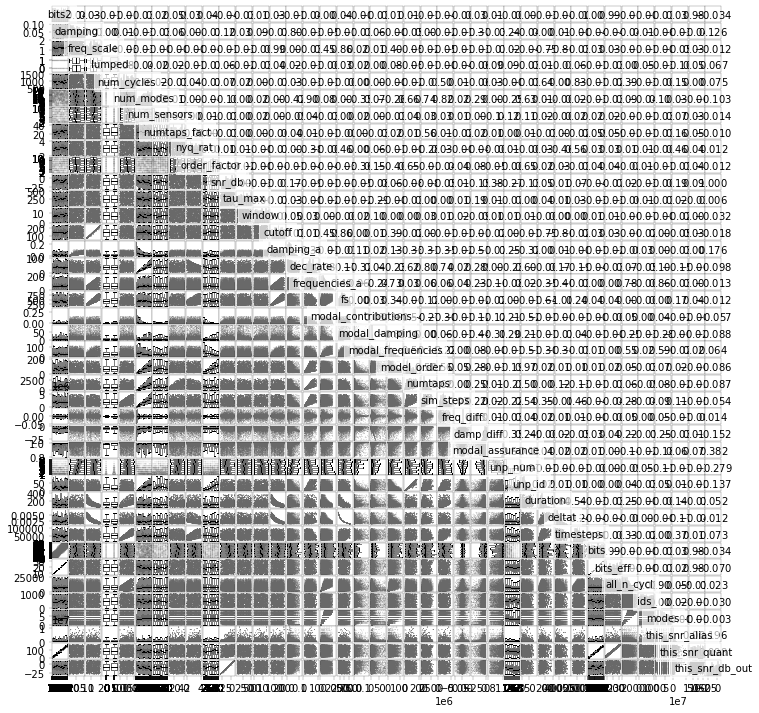

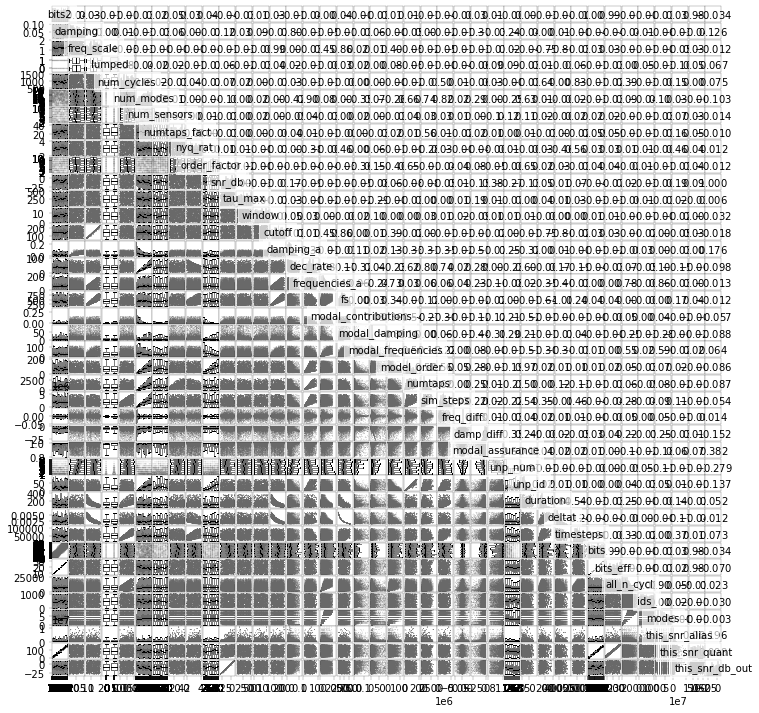

In [22]:
data_manager.post_process_samples(db='merged',func=func, rw=True)

In [23]:
with data_manager.get_database(database='out', rw=False) as ds:
    ds


# ds['duration'] = ds.num_cycles/ds.frequencies_a.min(dim='modes')

# #dt_fact=0.01
# #ds['deltat'] = dt_fact / ds.frequencies_a.max(dim='modes')
# #ds['timesteps'] = ds.duration / ds.deltat # N

# ds['all_n_cycl'] = ds.duration * ds.frequencies_a
# ds = ds.rename_dims({'ids':'ids_'})
# #display(ds)
# ds = ds.stack(ids=('ids_','modes'))
# #display(ds.ids_)
# ds = ds.dropna('ids','all')
# #display(ds)
# ds = ds.reset_index('ids')
display(ds.frequencies_a.dropna("ids", "all"))

DEBUG:uncertainty.data_manager:opening existing file uq_acqui_out.nc


<xarray.DataArray 'frequencies_a' (ids: 1000, modes: 100)>
array([[11.68195977, 35.04484834, 58.39865459, ...,         nan,
                nan,         nan],
       [ 5.95011732, 17.86100278, 29.76472618, ...,         nan,
                nan,         nan],
       [12.21913266, 36.71442198, 61.17780679, ...,         nan,
                nan,         nan],
       ...,
       [ 8.82115532, 26.53958418, 44.22532143, ...,         nan,
                nan,         nan],
       [11.75951435, 35.38756991, 58.97918972, ...,         nan,
                nan,         nan],
       [11.23779816, 33.79423881, 56.32164702, ...,         nan,
                nan,         nan]])
Coordinates:
  * ids      (ids) object 'd5c92dec8c49' '8db9e569abe9' ... '6892f3e8f39e'
Dimensions without coordinates: modes

In [25]:
with data_manager.get_database(database='processed', rw=True) as ds:
    #ds.unp_num.attrs = {'dist_type': 'integers', 'dist_params': np.array([1,9])}
    #ds.unp_id.attrs = {'dist_type': 'integers', 'dist_params': np.array([0,92])}
    #ds.dec_rate.attrs = {'dist_type': 'integers', 'dist_params': np.array([6,83])}
#     ds['window'] = ('ids', ds.window.data=='hann', {'dist_type': 'integers', 'dist_params': np.array([0,2])})
    #ds['numtaps_fact'] = ds.numtaps / ds.dec_rate #= ds.reset_coords(['ids_','modes'])
    #ds['nyq_rat'] = ds.fs/ds.cutoff
    #ds.to_netcdf('/usr/scratch4/sima9999/work/modal_uq/uq_acqui/uq_acqui_processed2.nc',engine='h5netcdf')
    ds['method'] = ('ids', ds.method.data=='welch', {'dist_type': 'integers', 'dist_params': np.array([0,2])})
    pass
display(ds)

DEBUG:uncertainty.data_manager:opening existing file uq_acqui_processed.nc
DEBUG:uncertainty.data_manager:Acquired lock on /vegas/scratch/womo1998/modal_uq/uq_acqui/uq_acqui_processed.nc.lock
DEBUG:uncertainty.data_manager:Saving database to /vegas/scratch/womo1998/modal_uq/uq_acqui/uq_acqui_processed.nc


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/xarray/backends/h5netcdf_.py:288: FutureWarning: complex dtypes are supported by h5py, but not part of the NetCDF API. You are writing an HDF5 file that is not a valid NetCDF file! In the future, this will be an error, unless you set invalid_netcdf=True.
  **kwargs,


<xarray.Dataset>
Dimensions:              (channels: 10, ids: 5952)
Dimensions without coordinates: channels, ids
Data variables:
    _exceptions          (ids) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    _runtimes            (ids) float64 58.4 58.4 58.4 58.4 ... 30.05 30.05 30.05
    all_n_cycl           (ids) float64 4.215e+03 7.024e+03 ... 6.68e+03
    bits                 (ids) float64 23.0 23.0 23.0 23.0 ... 32.0 32.0 32.0
    bits2                (ids) float64 23.0 23.0 23.0 23.0 ... 32.0 32.0 32.0
    bits_eff             (ids) float64 22.95 22.95 22.95 ... 31.94 31.94 31.94
    cutoff               (ids) float64 219.7 219.7 219.7 ... 208.6 208.6 208.6
    damp_diff            (ids) float64 -0.433 -0.3718 -0.3722 ... -6.458 -6.546
    damping              (ids) float64 0.01134 0.01134 0.01134 ... 0.0781 0.0781
    damping_a            (ids) float64 0.004798 0.004099 ... 0.03188 0.03553
    dec_rate             (ids) float64 57.0 57.0 57.0 57.0 ... 34.0 34.0 34.0
    deltat               (ids) float64 0.001727 0.001727 ... 0.001218 0.001218
    duration             (ids) float64 120.3 120.3 120.3 ... 65.94 65.94 65.94
    freq_diff            (ids) float64 -0.002171 2.643e-05 ... -0.002655
    freq_scale           (ids) float64 1.807 1.807 1.807 ... 1.744 1.744 1.744
    frequencies_a        (ids) float64 35.04 58.4 81.74 ... 56.32 78.83 101.3
    fs                   (ids) float64 579.2 579.2 579.2 ... 821.1 821.1 821.1
    ids_                 (ids) int64 0 0 0 0 0 0 0 ... 998 998 999 999 999 999
    lumped               (ids) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    margin               (channels, ids) float64 0.9649 0.9649 ... nan nan
    method               (ids) bool False False False False ... True True True
    modal_assurance      (ids) float64 0.995 0.9997 0.9993 ... 0.9078 0.82
    modal_contributions  (ids) float64 3.5e-05 1.513e-05 ... 0.001516 0.01022
    modal_damping        (ids) float64 33.69 11.55 21.85 ... 90.14 57.18 69.37
    modal_frequencies    (ids) float64 11.26 15.11 21.01 ... 11.65 12.77 31.06
    mode_shapes          (channels, ids) complex128 (2.9587932776365764e-10-7...
    mode_shapes_a        (channels, ids) complex128 (0.0013797692063104799+0....
    model_order          (ids) float64 135.0 135.0 135.0 ... 78.0 78.0 78.0
    modes                (ids) int64 1 2 3 4 5 6 7 8 0 1 ... 3 4 5 6 7 8 1 2 3 4
    num_cycles           (ids) float64 1.405e+03 1.405e+03 ... 741.0 741.0
    num_modes            (ids) float64 15.0 15.0 15.0 15.0 ... 13.0 13.0 13.0
    num_sensors          (ids) float64 8.0 8.0 8.0 8.0 8.0 ... 9.0 9.0 9.0 9.0
    numtaps              (ids) float64 638.0 638.0 638.0 ... 816.0 816.0 816.0
    numtaps_fact         (ids) float64 11.0 11.0 11.0 11.0 ... 24.0 24.0 24.0
    nyq_rat              (ids) float64 2.636 2.636 2.636 ... 3.937 3.937 3.937
    order_factor         (ids) float64 9.0 9.0 9.0 9.0 9.0 ... 6.0 6.0 6.0 6.0
    sim_steps            (ids) float64 4.04e+06 4.04e+06 ... 1.841e+06 1.841e+06
    snr_alias            (channels, ids) float64 2.644e+05 2.644e+05 ... nan nan
    snr_db               (ids) float64 -21.0 -21.0 -21.0 ... -22.01 -22.01
    snr_db_out           (channels, ids) float64 -21.0 -21.0 -21.0 ... nan nan
    snr_quant            (channels, ids) float64 101.6 101.6 101.6 ... nan nan
    tau_max              (ids) float64 78.0 78.0 78.0 78.0 ... 253.0 253.0 253.0
    this_snr_alias       (ids) float64 1.617e+05 1.617e+05 ... 1.167e+06
    this_snr_db_out      (ids) float64 -21.0 -21.0 -21.0 ... -22.01 -22.01
    this_snr_quant       (ids) float64 101.0 101.0 101.0 ... 156.4 156.4 156.4
    timesteps            (ids) float64 6.966e+04 6.966e+04 ... 5.414e+04
    unp_id               (ids) float64 57.0 57.0 57.0 57.0 ... 34.0 34.0 34.0
    unp_num              (ids) float64 1.0 1.0 1.0 1.0 1.0 ... 5.0 5.0 5.0 5.0
    window               (ids) float64 11.39 11.39 11.39 ... 13.34 13.34 13.34
Attributes:
    date:         datetime